In [29]:
import jsonlines
import torchaudio
from pathlib import Path
import torch, random
import librosa, os
import IPython.display as ipd
from dotenv import load_dotenv
from spellchecker import SpellChecker
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from collections import defaultdict
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

In [30]:
import jsonlines
import pandas as pd

data = {'image': [], 'caption': [], 'bbox': []}
load_dotenv()

TEAM_NAME = os.getenv("TEAM_NAME", "7up")
TEAM_TRACK = os.getenv("TEAM_TRACK", "advanced")


input_dir = Path(f"/home/jupyter/{TEAM_TRACK}")
with jsonlines.open(input_dir / "vlm.jsonl") as reader:
    for obj in reader:
        image = obj['image']
        annotations = obj['annotations']
        for annotation in annotations:
            caption = annotation['caption']
            bbox = annotation['bbox']
            data['image'].append(image)
            data['caption'].append(caption)
            data['bbox'].append(bbox)

df = pd.DataFrame(data)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df

,image,caption,bbox
11011,image_2018.jpg,orange and black fighter jet,"[244, 40, 56, 60]"
26255,image_4808.jpg,green and brown camouflage fighter jet,"[1016, 300, 80, 52]"
19592,image_3594.jpg,white light aircraft,"[676, 336, 76, 44]"
9683,image_1779.jpg,black fighter plane,"[920, 488, 56, 40]"
23,image_4.jpg,"white, red, and green fighter plane","[260, 232, 60, 56]"
...,...,...,...
21575,image_3968.jpg,green and brown camouflage fighter plane,"[632, 252, 92, 68]"
5390,image_987.jpg,"red, white, and blue light aircraft","[580, 472, 28, 40]"
860,image_162.jpg,blue and green fighter plane,"[868, 140, 68, 28]"
15795,image_2896.jpg,orange light aircraft,"[440, 236, 44, 24]"


In [37]:

def convert_to_coco(df):
    images = []
    annotations = []
    categories = [
    {
        "id": 1,
        "name": "missile",
        "supercategory": "aircraft"
    },
    {
        "id": 2,
        "name": "light aircraft",
        "supercategory": "aircraft"
    },
    {
        "id": 3,
        "name": "helicopter",
        "supercategory": "aircraft"
    },
    {
        "id": 4,
        "name": "drone",
        "supercategory": "aircraft"
    },
    {
        "id": 5,
        "name": "fighter jet",
        "supercategory": "aircraft"
    },
    {
        "id": 6,
        "name": "commercial aircraft",
        "supercategory": "aircraft"
    },
    {
        "id": 7,
        "name": "cargo aircraft",
        "supercategory": "aircraft"
    },
    {
        "id": 8,
        "name": "fighter plane",
        "supercategory": "aircraft"
    }
    ]
    category_name_to_id = {category['name']: category['id'] for category in categories}
    def find_category_id(caption):
        for category_name, category_id in category_name_to_id.items():
            if category_name in caption.lower():
                return category_id
        return None
    # Keep track of IDs
    image_id_map = {}
    annotation_id = 1
    image_id = 1

    for idx, row in df.iterrows():
        image = row['image']
        caption = row['caption']
        bbox = row['bbox']
        
        if image not in image_id_map:
            image_id_map[image] = image_id
            images.append({
                "id": image_id,
                "file_name": image,
                # Assuming width and height are not provided
                "width": None,
                "height": None
            })
            image_id += 1
            
        category_id = find_category_id(caption)
        annotations.append({
            "id": annotation_id,
            "image_id": image_id_map[image],
            "category_id": category_id,
            "bbox": bbox,
            "caption": caption,
            "area": bbox[2] * bbox[3],  # width * height
            "iscrowd": 0
        })
        annotation_id += 1
    
    coco_format = {
        "images": images,
        "annotations": annotations,
        "categories": categories,
        "licenses": []  # Assuming no license info is provided
    }
    
    return coco_format

# Convert the training and validation data to COCO format
train_coco = convert_to_coco(train_df)
val_coco = convert_to_coco(val_df)

with open("train_coco.json", 'w') as f:
    json.dump(train_coco, f)

with open("val_coco.json", 'w') as f:
    json.dump(val_coco, f)

print("Conversion to COCO format completed successfully.")


Conversion to COCO format completed successfully.


In [32]:
from datasets import load_dataset

# Load dataset from COCO JSON files
train_dataset = load_dataset("json", data_files="train_coco_annotations.json")
val_dataset = load_dataset("json", data_files="val_coco_annotations.json")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [13]:
# organized_data = defaultdict(lambda: {'captions': [], 'bboxes': []})

# for item in data:
#     organized_data[item['image']]['captions'].append(item['caption'])
#     organized_data[item['image']]['bboxes'].append(item['bbox'])

# dataset = []
# for image, annotations in organized_data.items():
#     dataset.append({
#         'image': image,
#         'captions': annotations['captions'],
#         'bboxes': annotations['bboxes']
#     })


# class VLMDataset(Dataset):
#     def __init__(self, dataframe, image_dir, tokenizer, transform=None):
#         self.dataframe = dataframe
#         self.image_dir = image_dir
#         self.tokenizer = tokenizer
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         row = self.dataframe.iloc[idx]
#         img_path = os.path.join(self.image_dir, row['image'])
#         image = Image.open(img_path).convert("RGB")
        
#         caption = row['caption']
#         bbox = row['bbox'] 

#         # Tokenize the caption
#         encoded_caption = self.tokenizer(caption, padding='max_length', max_length=128, truncation=True, return_tensors='pt')

#         if self.transform:
#             image = self.transform(image)
        
#         sample = {
#             "pixel_values": image,
#             "input_ids": encoded_caption['input_ids'].squeeze(),
#             "attention_mask": encoded_caption['attention_mask'].squeeze(),
#             "bbox": torch.tensor(bbox, dtype=torch.float)
#         }
        
#         return sample

# tokenizer = AutoTokenizer.from_pretrained("google/owlv2-base-patch16-ensemble")

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# image_dir = '/home/jupyter/advanced/images/'
# train_dataset = VLMDataset(dataframe=train_df, image_dir=image_dir, tokenizer=tokenizer, transform=transform)
# val_dataset = VLMDataset(dataframe=val_df, image_dir=image_dir, tokenizer=tokenizer, transform=transform)


In [33]:
# Print a few samples from the train_dataset
print(val_dataset)
print(train_dataset)

DatasetDict({
    train: Dataset({
        features: ['images', 'annotations', 'categories'],
        num_rows: 1
    })
})
DatasetDict({
    train: Dataset({
        features: ['images', 'annotations', 'categories'],
        num_rows: 1
    })
})


In [15]:
# def collate_fn(batch):
#     images = torch.stack([item['image'] for item in batch])
#     input_ids = torch.stack([item['input_ids'] for item in batch])
#     attention_masks = torch.stack([item['attention_mask'] for item in batch])
#     bboxes = torch.stack([item['bbox'] for item in batch])
    
#     return {
#         'image': images,
#         'input_ids': input_ids,
#         'attention_mask': attention_masks,
#         'bbox': bboxes
#     }

In [17]:
from transformers import DefaultDataCollator
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from transformers import AutoTokenizer, AutoModelForZeroShotObjectDetection, TrainingArguments, Trainer

model = AutoModelForZeroShotObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")
training_args = TrainingArguments(
    output_dir="./test_owlvit",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=3,
)

data_collator = DefaultDataCollator()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset['train'],  
    eval_dataset=val_dataset['train']   
)

trainer.train()

IndexError: Invalid key: 0 is out of bounds for size 0

In [4]:
# import pandas as pd
# import json


# # Convert DataFrame to COCO format
# coco_data = {
#     "images": [],
#     "annotations": [],
#     "categories": []
# }

# category_set = set()
# image_set = set()

# for idx, row in df.iterrows():
#     image_id = row['image'].split('.')[0]
#     if image_id not in image_set:
#         coco_data["images"].append({
#             "id": image_id,
#             "file_name": row['image']
#         })
#         image_set.add(image_id)
    
#     category_id = row['caption']
#     if category_id not in category_set:
#         coco_data["categories"].append({
#             "id": len(category_set) + 1,
#             "name": category_id
#         })
#         category_set.add(category_id)
    
#     coco_data["annotations"].append({
#         "id": idx,
#         "image_id": image_id,
#         "category_id": list(category_set).index(category_id) + 1,
#         "bbox": row['bbox'],
#         "area": row['bbox'][2] * row['bbox'][3],
#         "iscrowd": 0
#     })

# # Save the COCO formatted data
# with open('coco_format.json', 'w') as f:
#     json.dump(coco_data, f)


In [10]:
from transformers import AutoModelForZeroShotObjectDetection, TrainingArguments, Trainer, DefaultDataCollator
from datasets import load_dataset
from PIL import Image
import torch
import torchvision.transforms as T

# Load your dataset
dataset = load_dataset("json", data_files="coco_format.json")

transform = T.Compose([T.Resize((800, 800)), T.ToTensor()])

def preprocess(example):
    image_path = example['images']['file_name']
    image = Image.open(image_path)
    image = transform(image)
    
    boxes = example['annotations']['bbox']
    labels = example['annotations']['category_id']
    boxes = [[x1, y1, x2, y2] for x1, y1, x2, y2 in boxes]
    
    return {"image": image, "bboxes": boxes, "labels": labels}

dataset = dataset.map(preprocess, batched=True)

# Split dataset
train_test_split = dataset["train"].train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]
train_dataset

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

TypeError: list indices must be integers or slices, not str

In [13]:
from PIL import Image
from transformers import AutoProcessor
import torch
import torchvision.transforms as T

# Load the processor
processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")

# Preprocessing function
def preprocess(example):
    # Load the image
    image_path = example['images'][0]['file_name']  # Access the first image path
    image = Image.open(image_path)
    image = T.ToTensor()(image)

    # Convert boxes and labels
    boxes = [ann['bbox'] for ann in example['annotations']]
    labels = [ann['category_id'] for ann in example['annotations']]
    # Normalize boxes to [0, 1] range
    boxes = [[x1 / image.shape[2], y1 / image.shape[1], x2 / image.shape[2], y2 / image.shape[1]] for x1, y1, x2, y2 in boxes]

    # Encode inputs using the processor
    encoded_inputs = processor(images=image, annotations={"bbox": boxes, "category_id": labels}, return_tensors="pt")
    encoded_inputs["labels"] = torch.tensor(labels)
    encoded_inputs["boxes"] = torch.tensor(boxes)
    return encoded_inputs

# Apply the preprocessing to the dataset
dataset = dataset.map(preprocess, batched=True)


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

TypeError: list indices must be integers or slices, not str

In [22]:
import torch
import torchvision.transforms as transforms
from torchvision.models import vision_transformer as vit
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import numpy as np
import os
from transformers import TrainingArguments, Trainer, default_data_collator

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        bbox = eval(self.dataframe.iloc[idx, 3]) # Assuming bbox is in [x, y, width, height] format
        label = self.dataframe.iloc[idx, 1] # Assuming the second column contains labels
        
        if self.transform:
            image, bbox = self.transform(image, bbox)
            
        return image, {"bbox": torch.tensor([bbox]), "labels": torch.tensor([1])}, label

# Define transformations for data augmentation
def get_transform(train):
    if train:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
            transforms.ToTensor(),
        ])
    else:
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])

# Define your model
def get_object_detection_model(num_classes):
    model = vit.vit_base_patch16_224(pretrained=True) # Load pre-trained ViT model
    # Replace classification head with object detection head
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, num_classes + 1) # Add 1 for background class
    return model


# Define your dataset
dataset = CustomDataset(df, "home/jupyter/advanced/images/", transform=get_transform(train=True))

# Split dataset into train and validation
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), int(0.2*len(dataset))])

training_args = TrainingArguments(
    output_dir="./dino-7up",
    evaluation_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    max_steps=2200,
    eval_steps=200,
    logging_steps=200,
    remove_unused_columns=False,  # Important for object detection models
    weight_decay=0.01,
    push_to_hub=True,
)

# Create a default data collator
data_collator = default_data_collator

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

# Train the model
trainer.train()


ValueError: Sum of input lengths does not equal the length of the input dataset!

In [6]:
# load_dotenv()

# TEAM_NAME = os.getenv("TEAM_NAME", "7up")
# TEAM_TRACK = os.getenv("TEAM_TRACK", "advanced")


# input_dir = Path(f"/home/jupyter/{TEAM_TRACK}")
# # input_dir = Path(f"../../data/{TEAM_TRACK}/train")
# # results_dir = Path(f"/home/jupyter/{TEAM_NAME}")
# # # results_dir = Path("results")
# # results_dir.mkdir(parents=True, exist_ok=True)
# # data = {'image': [], 'annotations': []}
# # count = 0

# # with jsonlines.open(input_dir / "vlm.jsonl") as reader:
# #     for obj in reader:
# #         # if count < 2:  # Check if we have processed less than 10 entries
# #         data['image'].append(obj['image'])
# #         data['annotations'].append(obj['annotations'])
# #         # count += 1
# #         # else:
# #         #     break  


In [51]:
from torch.utils.data import Dataset
from transformers import AutoProcessor
from PIL import Image
import torch
import os
from torch.nn.utils.rnn import pad_sequence

class CustomDataset(Dataset):
    def __init__(self, image_paths, annotations, processor, max_caption_length, max_bbox_count):
        self.image_paths = image_paths
        self.annotations = annotations
        self.processor = processor
        self.max_caption_length = max_caption_length
        self.max_bbox_count = max_bbox_count

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open("/home/jupyter/advanced/images/" + image_path).convert("RGB")
        annotation = self.annotations[idx]
        captions = [ann['caption'] for ann in annotation]
        bboxes = [ann['bbox'] for ann in annotation]
        
        print("Image shape:", image.size)
        print("Captions shapes:", [len(c) for c in captions])
        print("Bboxes shapes:", [len(b) for b in bboxes])

        # Pad or truncate captions to the maximum length
        captions_padded = [text[:self.max_caption_length] + ' ' * max(0, self.max_caption_length - len(text)) for text in captions]
        
        # Pad or truncate bounding boxes to the maximum count and size
        padded_bboxes = []
        for bbox in bboxes:
            padded_bbox = bbox[:self.max_bbox_count] + [[0] * 4] * max(0, self.max_bbox_count - len(bbox))
            padded_bboxes.append(padded_bbox)
        
        inputs = self.processor(images=image, text=captions_padded, return_tensors="pt", padding=True, truncation=True)
        inputs['bboxes'] = torch.tensor(padded_bboxes, dtype=torch.float32)
        
        # Flatten the batch dimensions
        inputs = {k: v.squeeze() for k, v in inputs.items()}
        
        return inputs

In [52]:
import torch
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor, TrainingArguments, Trainer
from transformers import default_data_collator
from pathlib import Path
import json

# Initialize processor and model
processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

train_image_paths, test_image_paths, train_annotations, test_annotations = train_test_split(data['image'], data['annotations'], test_size=0.2, random_state=42)
max_caption_length = max(len(annotation['caption']) for annotations in train_annotations + test_annotations for annotation in annotations)
max_bbox_count = max(len(ann['bbox']) for annotations in train_annotations + test_annotations for ann in annotations)

train_dataset = CustomDataset(train_image_paths, train_annotations, processor, max_caption_length, max_bbox_count)
test_dataset = CustomDataset(test_image_paths, test_annotations, processor, max_caption_length, max_bbox_count)

print(train_dataset)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [53]:
training_args = TrainingArguments(
    output_dir="./dino-7up",
    evaluation_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    max_steps=2200,
    eval_steps=200,
    logging_steps=200,
    remove_unused_columns=False,  # Important for object detection models
    weight_decay=0.01,
    push_to_hub=True,
)

# Define a data collator
data_collator = default_data_collator

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

# Fine-tune the model
trainer.train()

max_steps is given, it will override any value given in num_train_epochs


Image shape: (1520, 870)
Captions shapes: [29, 34, 35]
Bboxes shapes: [4, 4, 4]
Image shape: (1520, 870)
Captions shapes: [27, 32, 40, 29, 40, 22]
Bboxes shapes: [4, 4, 4, 4, 4, 4]
Image shape: (1520, 870)
Captions shapes: [37, 24, 38, 19, 23]
Bboxes shapes: [4, 4, 4, 4, 4]
Image shape: (1520, 870)
Captions shapes: [27, 14, 20, 27, 21]
Bboxes shapes: [4, 4, 4, 4, 4]


RuntimeError: stack expects each tensor to be equal size, but got [3, 7] at entry 0 and [6, 10] at entry 1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

def compute_iou(box1, box2):
    """
    Compute the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1 (list): [xmin, ymin, xmax, ymax] of the first bounding box.
        box2 (list): [xmin, ymin, xmax, ymax] of the second bounding box.

    Returns:
        float: IoU score.
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of intersection
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No overlap

    # Calculate area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate area of individual boxes
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Calculate Union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou


def remove_overlapping_boxes(scores, labels, boxes, threshold=0.5):
    """
    Remove overlapping bounding boxes using Non-Maximum Suppression (NMS).

    Args:
        scores (list): Confidence scores of bounding boxes.
        labels (list): Predicted labels of bounding boxes.
        boxes (list): Coordinates of bounding boxes in the format [xmin, ymin, xmax, ymax].
        threshold (float): IoU threshold to consider bounding boxes as overlapping.

    Returns:
        tuple: Tuple containing scores, labels, and boxes after NMS.
    """
    num_boxes = len(scores)
    sorted_indices = sorted(range(num_boxes), key=lambda i: scores[i], reverse=True)

    keep = []
    while len(sorted_indices) > 0:
        # Pick the box with the highest score
        picked_index = sorted_indices[0]
        keep.append(picked_index)

        # Compute IoU of the picked box with other boxes
        picked_box = boxes[picked_index]
        mask = [compute_iou(picked_box, boxes[idx]) < threshold for idx in sorted_indices[1:]]
        
        # Remove the picked box and all boxes with high IoU from consideration
        sorted_indices = [sorted_indices[i + 1] for i, m in enumerate(mask) if m]

    # Filter out selected scores, labels, and boxes
    selected_scores = [scores[idx] for idx in keep]
    selected_labels = [labels[idx] for idx in keep]
    selected_boxes = [boxes[idx] for idx in keep]

    return selected_scores, selected_labels, selected_boxes

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label_idx, (xmin, ymin, xmax, ymax), c in zip(scores, labels, boxes, colors):
        label_name = model.config.id2label[label_idx.item()]
        if (label_name == 'airplane' and score > 0.2) or (label_name == 'kite' and score > 0.2) or (label_name == 'bird' and score > 0.2):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=c, linewidth=3))
            text = f'{label_name}: {score:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
def apply_clahe(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
    clahe_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return clahe_img

def convert_to_greyscale(image):
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grey_image = np.stack((grey_image,)*3, axis=-1)  # Convert back to 3-channel image
    return grey_image

In [96]:
# import torch, cv2
# from transformers import DetrImageProcessor, DetrForObjectDetection


# # Load DETR model
# model_name = "facebook/detr-resnet-50"
# processor = DetrImageProcessor.from_pretrained(model_name)
# model = DetrForObjectDetection.from_pretrained(model_name)

# for image_path in data['image']:
#     # Load an image
#     image_path = input_dir / "images" / image_path  # Change this to your image path
#     image = cv2.imread(str(image_path))
    
#     image = convert_to_greyscale(image)

#     # Convert to tensor
#     image = torch.tensor(image)
#     # Preprocess the image
#     inputs = processor(images=image, return_tensors="pt")

#     with torch.no_grad():
#         outputs = model(**inputs)

#     height = image.size(0)
#     width = image.size(1)
#     postprocessed_outputs = processor.post_process_object_detection(outputs,
#                                                                     target_sizes=[(height, width)],
#                                                                     threshold=0.01)
#     results = postprocessed_outputs[0]
#     scores, labels, boxes = remove_overlapping_boxes(results['scores'], results['labels'], results['boxes'])
#     plot_results(image, scores, labels, boxes)
     


You are using a model of type owlvit to instantiate a model of type detr. This is not supported for all configurations of models and can yield errors.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at google/owlvit-base-patch32 and are newly initialized: ['backbone.conv_encoder.model.bn1.bias', 'backbone.conv_encoder.model.bn1.running_mean', 'backbone.conv_encoder.model.bn1.running_var', 'backbone.conv_encoder.model.bn1.weight', 'backbone.conv_encoder.model.conv1.weight', 'backbone.conv_encoder.model.layer1.0.bn1.bias', 'backbone.conv_encoder.model.layer1.0.bn1.running_mean', 'backbone.conv_encoder.model.layer1.0.bn1.running_var', 'backbone.conv_encoder.model.layer1.0.bn1.weight', 'backbone.conv_encoder.model.layer1.0.bn2.bias', 'backbone.conv_encoder.model.layer1.0.bn2.running_mean', 'backbone.conv_encoder.model.layer1.0.bn2.running_var', 'backbone.conv_encoder.model.layer1.0.bn2.weight', 'backbone.conv_encoder.model.layer1.0.bn3.bias', 'backbone

tensor(0)
[tensor(0.4713)] [tensor(0)] [tensor([ 372.7099,  216.6127, 1136.2250,  653.6396])]


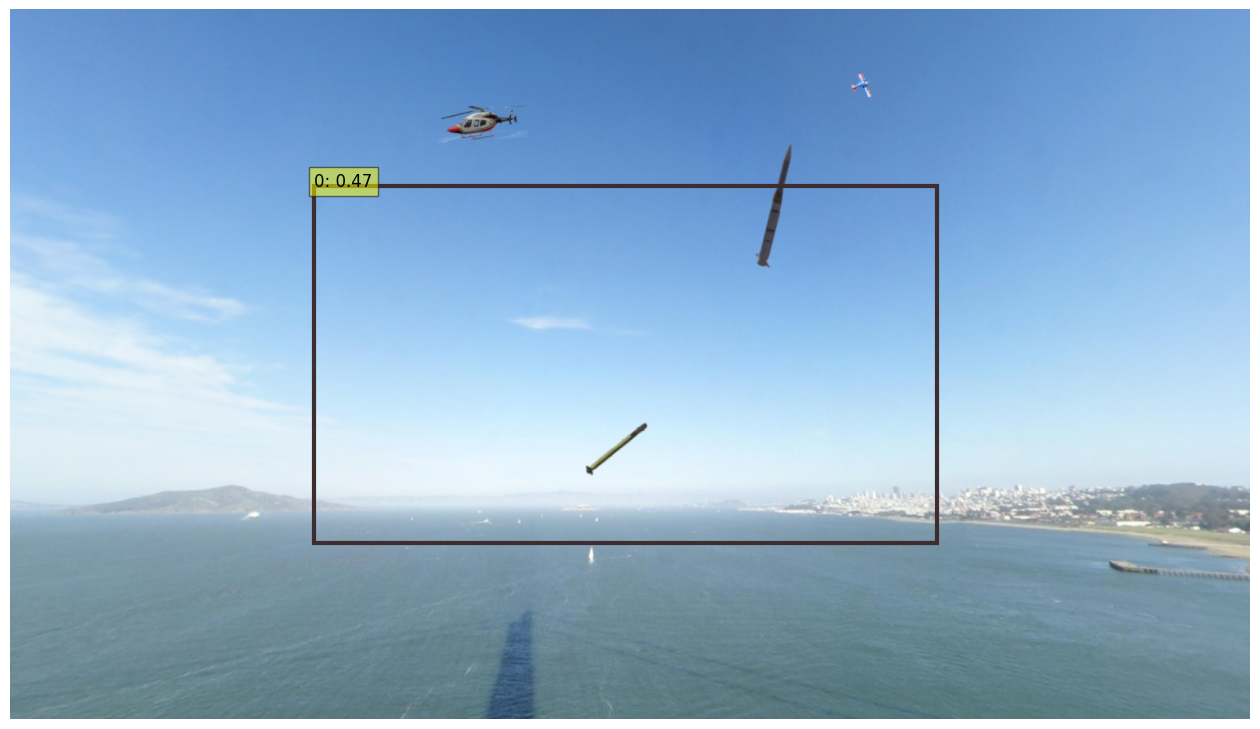

tensor(0)
[tensor(0.4710)] [tensor(0)] [tensor([ 372.6943,  216.6275, 1136.2347,  653.6561])]


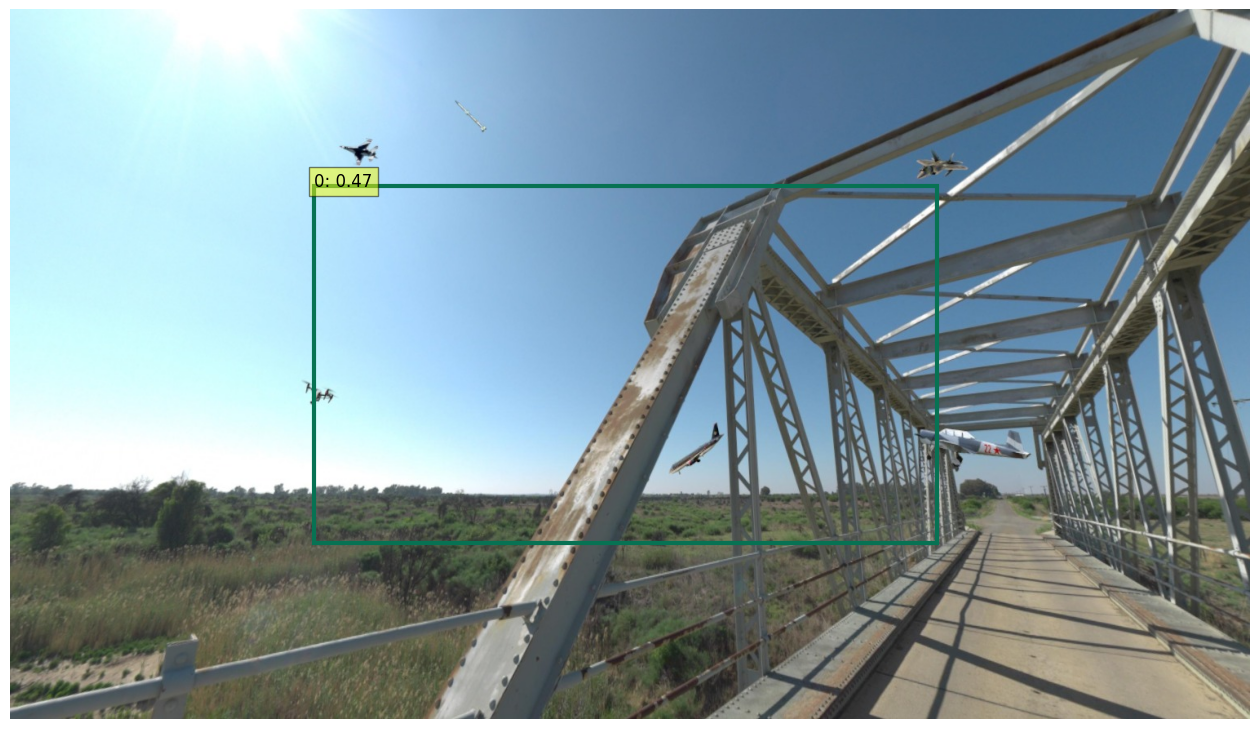

In [103]:
import torch
import cv2
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the model name
model_name = "google/owlvit-base-patch32"

# Load the processor and model
processor = DetrImageProcessor.from_pretrained(model_name)
model = DetrForObjectDetection.from_pretrained(model_name)

# Function to plot results
def plot_results(image, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()
    colors = np.random.rand(len(boxes), 3)  # Random colors for each box

    for score, label, (xmin, ymin, xmax, ymax), color in zip(scores, labels, boxes, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=color, linewidth=3))
        ax.text(xmin, ymin, f'{label}: {score:.2f}', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()


# Function to filter results by target labels
def filter_results_by_labels(scores, labels, boxes, target_labels):
    filtered_scores = []
    filtered_labels = []
    filtered_boxes = []
    for score, label, box in zip(scores, labels, boxes):
        
        if label not in target_labels:
            print(label)
            filtered_scores.append(score)
            filtered_labels.append(label)
            filtered_boxes.append(box)
    return filtered_scores, filtered_labels, filtered_boxes

# Example image path
for image_path in data['image']:
    # Load an image
    image_path = input_dir / "images" / image_path  # Change this to your image path
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Convert to PIL image
    image_pil = Image.fromarray(image)

    # Preprocess the image
    inputs = processor(images=image_pil, return_tensors="pt")

    # Perform object detection
    with torch.no_grad():
        outputs = model(**inputs)

    # Get image dimensions
    height, width = image.shape[:2]

    # Postprocess the outputs
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.01)
    results = postprocessed_outputs[0]
    scores, labels, boxes = remove_overlapping_boxes(results['scores'], results['labels'], results['boxes'])

    # Define target labels (example: finding "person" and "car")
    target_labels = ["airplane", "missle", "fighter jet", "aircraft", "helicopter", "aeroplane"]

    # Filter results by target labels
    filtered_scores, filtered_labels, filtered_boxes = filter_results_by_labels(scores, labels, boxes, target_labels)
    print(filtered_scores, filtered_labels, filtered_boxes)
    # Plot the filtered results
    plot_results(image, filtered_scores, filtered_labels, filtered_boxes)


In [110]:
from transformers import pipeline
from transformers import AutoImageProcessor, AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image, ImageDraw
import cv2
import numpy as np
from pathlib import Path

# Using image processor from detr
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

checkpoint = "google/owlvit-base-patch32"
processor = AutoProcessor.from_pretrained(checkpoint)

# Define labels and create the model
id2label = {
    0: "airplane",
    1: "missile",
    2: "fighter jet",
    3: "aircraft",
    4: "helicopter",
    5: "aeroplane"
}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForZeroShotObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

detector = pipeline(model=model, processor=image_processor, task="zero-shot-object-detection")


from PIL import ImageDraw

for image_path in data['image']:
    # Load an image
    image_path = input_dir / "images" / image_path  # Change this to your image path
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pil_image = Image.fromarray(image)
    draw = ImageDraw.Draw(pil_image)
    
    # Run the detection
    predictions = detector(
        image,
        candidate_labels=["airplane", "missile", "fighter jet", "aircraft", "helicopter", "aeroplane"],
        threshold=0.01,
        top_k=8
    )
    
    for prediction in predictions[0]:
        box = prediction["box"]
        label = prediction["label"]
        score = prediction["score"]

        xmin, ymin, xmax, ymax = box.values()
        draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
        draw.text((xmin, ymin), f"{label}: {round(score, 2)}", fill="white")

    # Show the image with bounding boxes (for debugging purposes)
    pil_image.show()

Exception: Impossible to guess which tokenizer to use. Please provide a PreTrainedTokenizer class or a path/identifier to a pretrained tokenizer.